In [51]:
# imports
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import pathlib as Path
import json
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [52]:
# Multiclass CNN performance metric functions

def calculate_cnn_precision_multiclass(y_true, y_pred):
    """
    Calculate the precision of a CNN model for a 4-class classifier using one-hot encoding.
    
    Args:
    y_true (numpy.ndarray): Ground truth labels (one-hot encoded)
    y_pred (numpy.ndarray): Predicted probabilities for each class
    
    Returns:
    numpy.ndarray: Precision score for each class
    float: Average precision across all classes
    """
    
    # Convert predicted probabilities to class predictions
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Number of classes
    num_classes = y_true.shape[1]
    
    # Initialize arrays to store true positives and predicted positives
    true_positives = np.zeros(num_classes)
    predicted_positives = np.zeros(num_classes)
    
    # Calculate true positives and predicted positives for each class
    for i in range(num_classes):
        true_positives[i] = np.sum((np.argmax(y_true, axis=1) == i) & (y_pred_classes == i))
        predicted_positives[i] = np.sum(y_pred_classes == i)
    
    # Calculate precision for each class
    precision = true_positives / (predicted_positives + 1e-7)
    
    # Calculate average precision
    average_precision = np.mean(precision)
    
    return precision, average_precision

def calculate_cnn_recall_multiclass(y_true, y_pred):
    """
    Calculate the recall of a CNN model for a 4-class classifier using one-hot encoding.
    
    Args:
    y_true (numpy.ndarray): Ground truth labels (one-hot encoded)
    y_pred (numpy.ndarray): Predicted probabilities for each class
    
    Returns:
    numpy.ndarray: Recall score for each class
    float: Average recall across all classes
    """
    
    # Convert predicted probabilities to class predictions
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Number of classes
    num_classes = y_true.shape[1]
    
    # Initialize arrays to store true positives and actual positives
    true_positives = np.zeros(num_classes)
    actual_positives = np.zeros(num_classes)
    
    # Calculate true positives and actual positives for each class
    for i in range(num_classes):
        true_positives[i] = np.sum((np.argmax(y_true, axis=1) == i) & (y_pred_classes == i))
        actual_positives[i] = np.sum(np.argmax(y_true, axis=1) == i)
    
    # Calculate recall for each class
    recall = true_positives / (actual_positives + 1e-7)
    
    # Calculate average recall
    average_recall = np.mean(recall)
    
    return recall, average_recall

def calculate_cnn_f1_score_multiclass(y_true, y_pred):
    """
    Calculate the F1 score of a CNN model for a 4-class classifier using one-hot encoding.
    
    Args:
    y_true (numpy.ndarray): Ground truth labels (one-hot encoded)
    y_pred (numpy.ndarray): Predicted probabilities for each class
    
    Returns:
    numpy.ndarray: F1 score for each class
    float: Average F1 score across all classes
    """
    
    # Calculate precision and recall
    precision, _ = calculate_cnn_precision_multiclass(y_true, y_pred)
    recall, _ = calculate_cnn_recall_multiclass(y_true, y_pred)
    
    # Calculate F1 score for each class
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
    
    # Calculate average F1 score
    average_f1_score = np.mean(f1_score)
    
    return f1_score, average_f1_score

def calculate_cnn_accuracy_multiclass(y_true, y_pred):
    """
    Calculate the accuracy of a CNN model for a 4-class classifier using one-hot encoding.
    
    Args:
    y_true (numpy.ndarray): Ground truth labels (one-hot encoded)
    y_pred (numpy.ndarray): Predicted probabilities for each class
    
    Returns:
    numpy.ndarray: Accuracy score for each class
    float: Overall accuracy across all classes
    """
    
    # Convert predicted probabilities to class predictions
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)
    
    # Number of classes
    num_classes = y_true.shape[1]
    
    # Initialize arrays to store correct predictions and total predictions
    correct_predictions = np.zeros(num_classes)
    total_predictions = np.zeros(num_classes)
    
    # Calculate correct predictions and total predictions for each class
    for i in range(num_classes):
        correct_predictions[i] = np.sum((y_true_classes == i) & (y_pred_classes == i))
        total_predictions[i] = np.sum(y_true_classes == i)
    
    # Calculate accuracy for each class
    class_accuracy = correct_predictions / (total_predictions + 1e-7)
    
    # Calculate overall accuracy
    overall_accuracy = np.sum(correct_predictions) / len(y_true_classes)
    
    return class_accuracy, overall_accuracy

In [53]:
# functions

def find_json_file(directory):
    """
    Find a JSON file in a directory (and its subdirectories) and load it into a dictionary.
    
    Parameters:
        directory (str): Path to the directory to search.
    
    Returns:
        dict or None: Dictionary containing the JSON data if a file is found, 
                      None otherwise.
    """
    for root, dirs, files in os.walk(directory):
        for file_name in files:
            if file_name.endswith('.json'):
                file_path = os.path.join(root, file_name)
                with open(file_path, 'r') as file:
                    try:
                        json_data = json.load(file)
                        return json_data
                    except json.JSONDecodeError:
                        print(f"Error: JSON decode failed for file '{file_path}'")
    print("No JSON file found in the directory.")
    return None

def one_hot_encode_max(arr):
    # Ensure the array is a numpy array for efficient processing
    arr = np.array(arr)
    
    # Create an array of zeros with the same shape as the input
    one_hot = np.zeros_like(arr)
    
    # For each row, set the position of the max value to 1
    max_indices = np.argmax(arr, axis=1)  # Get index of max value in each row
    one_hot[np.arange(arr.shape[0]), max_indices] = 1  # Set 1 at max index positions
    
    return one_hot

def find_threshold(y_pred, y_true, threshold_range=np.arange(0.5, 1.0, 0.02)):

    # Get the indices of the highest values for each array
    true_max_indices = np.argmax(y_true, axis=1)
    pred_max_indices = np.argmax(y_pred, axis=1)

    # Get the highest predicted values
    pred_max_values = np.max(y_pred, axis=1)

    best_f1 = 0
    best_threshold = 0

    # Loop over the threshold range to find the best threshold
    for threshold in threshold_range:
        # Create a mask where the indices match and values are above threshold
        final_mask = (true_max_indices == pred_max_indices) & (pred_max_values >= threshold)

        # Create output array of zeros with the same shape as y_pred
        output = np.zeros_like(y_pred)

        # Set values where conditions are met
        output[final_mask] = y_pred[final_mask]

        output = one_hot_encode_max(output)
        
        # Calculate precision, recall, F1-score for this threshold
        precision = precision_score(y_true, output, average='weighted', zero_division=0)
        recall = recall_score      (y_true, output, average='weighted', zero_division=0)
        f1 = f1_score              (y_true, output, average='weighted', zero_division=0)

        # print(f'Threshold: {threshold}, Precision: {precision}, Recall: {recall}, F1: {f1}')

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    # Create a mask where the indices match and values are above threshold
    final_mask = (true_max_indices == pred_max_indices) & (pred_max_values >= best_threshold)

    # Create output array of zeros with the same shape as y_pred
    output = np.zeros_like(y_pred)

    # Set values where conditions are met
    output[final_mask] = y_pred[final_mask]

    output = one_hot_encode_max(output)

    # Calculate precision, recall, F1-score for this threshold
    precision = precision_score(y_true, output, average=None, zero_division=0)
    recall = recall_score      (y_true, output, average=None, zero_division=0)
    f1 = f1_score              (y_true, output, average=None, zero_division=0)
    
    print(output)
    print(y_true)

    print(precision)
    print(recall)
    print(f1)

    print(f'Best Threshold: {best_threshold} with F1 Score: {best_f1}')
    
    return best_threshold, best_f1

def analyze_predictions(predicted_values, true_values):  # roc method
    correct_confidences = []
    incorrect_confidences = []
    
    for pred, true in zip(predicted_values, true_values):
        predicted_class = np.argmax(pred)
        true_class = np.argmax(true)
        confidence = np.max(pred)
        
        if predicted_class == true_class:
            correct_confidences.append(confidence)
        else:
            incorrect_confidences.append(confidence)

    # Combine confidences and create binary labels
    all_confidences = np.array(correct_confidences + incorrect_confidences)
    all_labels = np.array([1] * len(correct_confidences) + [0] * len(incorrect_confidences))
    
    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_confidences)
    roc_auc = auc(fpr, tpr)
    
    # Find the optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    print('data size',len(correct_confidences) + len(incorrect_confidences))
    print('number of "correct" predictions', len(correct_confidences))
    print('number of "incorrect" predictions', len(incorrect_confidences))

    num_bins = 100
    bin_range = (0,1)
    # Compute histograms with the same range and bins
    hist1, bins = np.histogram(correct_confidences, bins=num_bins, range=bin_range,density=False)
    hist2, _ = np.histogram(incorrect_confidences, bins=num_bins, range=bin_range,density= False)

    hist1 = hist1  / (len(predicted_values))  
    hist2 = hist2  / (len(predicted_values))  

    # Set the bin centers for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Plot histograms
    plt.figure(figsize=(8, 6))

    # Plot the first histogram (going up)
    plt.bar(bin_centers, hist1, width=(bins[1] - bins[0]), color='blue', alpha=0.5, label='Correct confidences')

    # Plot the second histogram (going down)
    plt.bar(bin_centers, -hist2, width=(bins[1] - bins[0]), color='red', alpha=0.5, label='Incorrect confidences')

    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histograms of Array 1 and Array 2')

    print('Total accuracy on the given data :',len(correct_confidences)/ (len(correct_confidences) + len(incorrect_confidences)))
    plt.grid('True')
    
    # find the average confidences for correct and incorrect predictions
    avg_correct_confidence = np.mean(correct_confidences) if correct_confidences else 0
    avg_incorrect_confidence = np.mean(incorrect_confidences) if incorrect_confidences else 0

    # Take the mean between them
    threshold = (avg_correct_confidence + avg_incorrect_confidence) / 2

    # plot the threshold value
    plt.axvline(threshold, label = 'threshold',color = 'g')

    # plot optimal threshold using ROC AUC
    plt.axvline(optimal_threshold,label = 'optimal threshold', color = 'y')
    
    
    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

    return avg_correct_confidence, avg_incorrect_confidence, optimal_threshold, roc_auc, fpr, tpr, thresholds

# function to optimize for f1 score
def optimize_threshold_f1(predicted_values, true_values, num_classes=4):
    def apply_threshold(predictions, threshold):
        return (predictions >= threshold).astype(int)

    # Convert true_values to one-hot encoding if not already
    if true_values.ndim == 1:
        true_values = label_binarize(true_values, classes=range(num_classes))

    thresholds = np.linspace(0, 1, 100)
    f1_scores = []

    for threshold in thresholds:
        # Apply threshold to predicted probabilities
        thresholded_preds = np.apply_along_axis(apply_threshold, 1, predicted_values, threshold)
        
        # Calculate macro F1 score
        macro_f1 = f1_score(true_values, thresholded_preds, average='macro')
        f1_scores.append(macro_f1)

    # Find the threshold that maximizes the F1 score
    best_threshold_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_idx]
    best_f1_score = f1_scores[best_threshold_idx]

    return best_threshold, best_f1_score, thresholds, f1_scores

#Function for unidentified class
def predict_with_unidentified(model, data, threshold=0.7):
    predictions = model.predict(data)
    max_prob = np.max(predictions, axis=1)
    labels = np.argmax(predictions, axis=1)
    labels[max_prob < threshold] = 4
    
    unidentified_count = np.sum(max_prob < threshold)
    return labels, unidentified_count

#using the threshold for analyzing
def analyze_predictions_with_threshold(predicted_values, true_values, confidence_threshold):
    confidently_right = 0
    confidently_wrong = 0
    uncertain = 0
    total = len(predicted_values)
    
    for pred, true in zip(predicted_values, true_values):
        predicted_class = np.argmax(pred)
        true_class = np.argmax(true)
        confidence = np.max(pred)
        
        if confidence >= confidence_threshold:
            if predicted_class == true_class:
                confidently_right += 1
            else:
                confidently_wrong += 1
        else:
            uncertain += 1
    
    percent_confidently_right = (confidently_right / total) * 100
    percent_confidently_wrong = (confidently_wrong / total) * 100
    percent_uncertain = (uncertain / total) * 100
    
    return percent_confidently_right, percent_confidently_wrong, percent_uncertain


Arpan's model MI-DCL

In [54]:
# Path
dir_path = r"C:\Users\arpan\OneDrive\Documents\GRB\data\DCL_ds0"   

# Check if the path exists
if os.path.exists(dir_path):
    print(f"The path '{dir_path}' exists.")
else:
    print(f"The path '{dir_path}' does not exist.")


# importing data
event_types = {1:'GRB',2:'TGF',3:'SGR',4:'SFLARE'}

test_dir = os.path.join(dir_path,"test")  
train_dir = os.path.join(dir_path,"train")

# Replace 'your_search_string' with the string you are looking for in file names
search_string = 'bn'

search_pattern = os.path.join(test_dir, f'*{search_string}*')
test_files = glob.glob(search_pattern)

search_pattern = os.path.join(train_dir, f'*{search_string}*')
train_files = glob.glob(search_pattern)

json_data = find_json_file(dir_path)
print(json_data)

dno = json_data['number of data points']

try:
    inup = json_data['include unprocessed']
except:
    inup = False
try:
    chrn = json_data['channel ranges']
except:
    chrn = 1
    
try:
    t = json_data['time interval'][1]-json_data['time interval'][0]
except:
    t='n/a'
    
# Calculating the number of points in each binnning
bin_list = json_data['bin list']
extra = 2 if inup else 1
dno_list = (len(bin_list)) * (len(chrn)*extra)  * [dno]
data_total = sum(dno_list)

fileno = 98
# Open the file in read mode
with open(train_files[fileno], 'r') as file:
    # Read all lines into a list
    lines = file.readlines()
print('hello',train_files[fileno],len(lines))

check_data = np.loadtxt(train_files[fileno], delimiter=' ').astype(np.int32)
len_data = len(check_data)

print(dno_list)
if data_total == len_data and len(dno_list) == (len(bin_list)) * (len(chrn)*extra):
    print('bin edges calculated correctly')
    print(data_total)
    print(len_data)
else:
    print('inconsistency in bin edges calculated and data')
    print(data_total)
    print(len_data)
    
print('channel range no',chrn)
print('number of data points',dno)
print('time interval',t)



def process_file(file, X,Y,event_counter,inup = inup, dno_list = dno_list): # for MI-DCL
    """
    takes a file and processes it and adds it to the data set
    file:path to the file to be processed
    X:data set to be added to
    Y:list of labels of data
    dno_list:list of number of data points in each binning as calculated previously
    
    returns updated X and Y and event_counter
    """
    # fetching data from file and checking if label is considered
    event_type , event_name = file.split('\\')[-1].split('_') # changed here for difference in path structure
    loaded_data = np.loadtxt(file, delimiter='\t').astype(np.float32)
    if event_type not in event_counter.keys():
        return X,Y,event_counter
    
    y = [0,0,0,0]
    
    # setting and updating Y
    for key,value in event_types.items():
        if value in file.split('\\')[-1]:
            y[key-1] = 1
            Y.append(y)
            event_counter[value] += 1
            
    extra = 2 if inup else 1
    
    # setting and updating X
    f = 0
    for k,dno in zip(X.keys(),dno_list):
        datlist = []
        for i in range(len(chrn) * extra):
            datlist.append(loaded_data[f:f+dno])
            f = f + int(dno)
#         print(len(datlist))
        X[k].append(np.array(datlist).transpose())
        
    return X,Y,event_counter

# initializing train and test sets
X_train = {str(key): [] for key in bin_list}
Y_train = []
train_event_counter = {'GRB':0,'TGF':0,'SGR':0,'SFLARE':0}

X_test = {str(key): [] for key in bin_list}
Y_test = []
test_event_counter = {'GRB':0,'TGF':0,'SGR':0,'SFLARE':0}

# print(process_file(train_files[1],X_train,Y_train,train_event_counter,inup))

# processing train and test data sets for MI-DCL
for file in train_files[:]:
    X_train,Y_train,train_event_counter = process_file(file,X_train,Y_train,train_event_counter,inup = inup, dno_list = dno_list)
print('training events\n',train_event_counter)
print('total events : ', sum([i for i in train_event_counter.values()]))
Y_train = np.array(Y_train)
print('shape of Y_train', Y_train.shape)
print('shape of X_train dictionary:')
for i in X_train.keys():
    X_train[i] = np.array(X_train[i])
#     X_train[i] = np.reshape(X_train[i], X_train[i].shape + tuple([1]))
    print(type(X_train[i]),X_train[i].shape)

for file in test_files[:]:
    X_test,Y_test,test_event_counter = process_file(file,X_test,Y_test,test_event_counter,inup = inup, dno_list = dno_list)
print('testing events\n',test_event_counter)
print('total events : ', sum([i for i in test_event_counter.values()]))
Y_test = np.array(Y_test)
print('shape of Y_test', Y_test.shape)
print('shape of X_test dictionary:')
for i in X_test.keys():
    X_test[i] = np.array(X_test[i])
#     X_test[i] = np.reshape(X_test[i], X_test[i].shape + tuple([1]))
    print(type(X_test[i]),X_test[i].shape)

The path 'C:\Users\arpan\OneDrive\Documents\GRB\data\DCL_ds0' exists.
{'bin list': [0.001, 0.005, 0.01, 0.1, 0.5, 1, 5], 'time interval': 'n/a', 'number of data points': 499, 'data set name': 'DCL_ds0', 'data set path': 'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\DCL_ds0', 'channel ranges': [[3, 50], [51, 124]], 'ratio': 0.25}
hello C:\Users\arpan\OneDrive\Documents\GRB\data\DCL_ds0\train\GRB_bn100325275 6986
[499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499]
bin edges calculated correctly
6986
6986
channel range no [[3, 50], [51, 124]]
number of data points 499
time interval n/a
training events
 {'GRB': 800, 'TGF': 800, 'SGR': 800, 'SFLARE': 800}
total events :  3200
shape of Y_train (3200, 4)
shape of X_train dictionary:
<class 'numpy.ndarray'> (3200, 499, 2)
<class 'numpy.ndarray'> (3200, 499, 2)
<class 'numpy.ndarray'> (3200, 499, 2)
<class 'numpy.ndarray'> (3200, 499, 2)
<class 'numpy.ndarray'> (3200, 499, 2)
<class 'numpy.ndarray'> (3200, 499, 2)
<class

In [55]:
# Load the model
from keras.models import load_model
model_path = r"C:\Users\arpan\OneDrive\Desktop\saved models\old bins 1\DCL.keras" # MI-DCL model
model = load_model(model_path)

In [56]:
y_pred_train = model.predict(X_train)

100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step


In [57]:
# threshold, F1 = find_threshold(y_pred_train,Y_train,threshold_range=np.arange(0.5, 1, 0.01))

Best threshold: 0.4444
Best macro F1 score: 0.9367


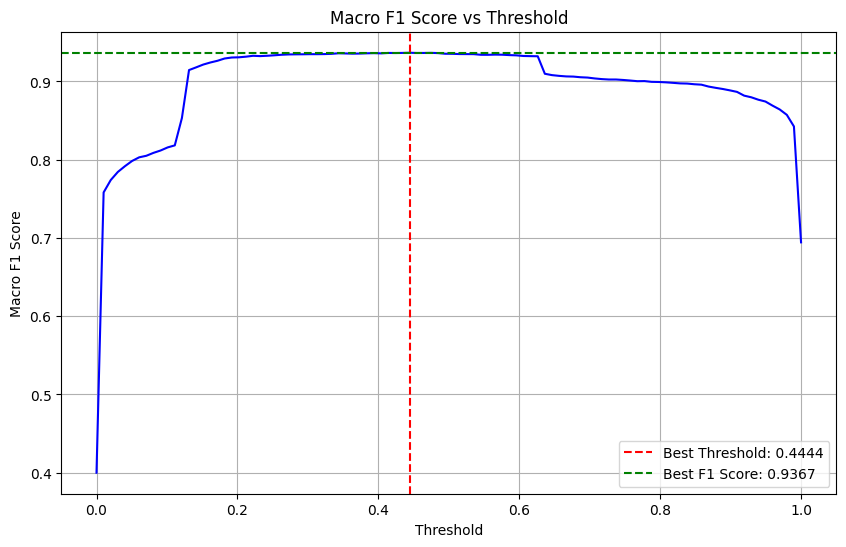

In [58]:
# opitimize f1 score
f1_threshold, best_f1_score, thresholds, f1_scores = optimize_threshold_f1(y_pred_train, Y_train)

print(f"Best threshold: {f1_threshold:.4f}")
print(f"Best macro F1 score: {best_f1_score:.4f}")

# Optional: Plot F1 scores vs thresholds
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, 'b-')
plt.xlabel('Threshold')
plt.ylabel('Macro F1 Score')
plt.title('Macro F1 Score vs Threshold')
plt.axvline(x=f1_threshold, color='r', linestyle='--', label=f'Best Threshold: {f1_threshold:.4f}')
plt.axhline(y=best_f1_score, color='g', linestyle='--', label=f'Best F1 Score: {best_f1_score:.4f}')
plt.legend()
plt.grid(True)
plt.show()

data size 3200
number of "correct" predictions 2990
number of "incorrect" predictions 210
Total accuracy on the given data : 0.934375


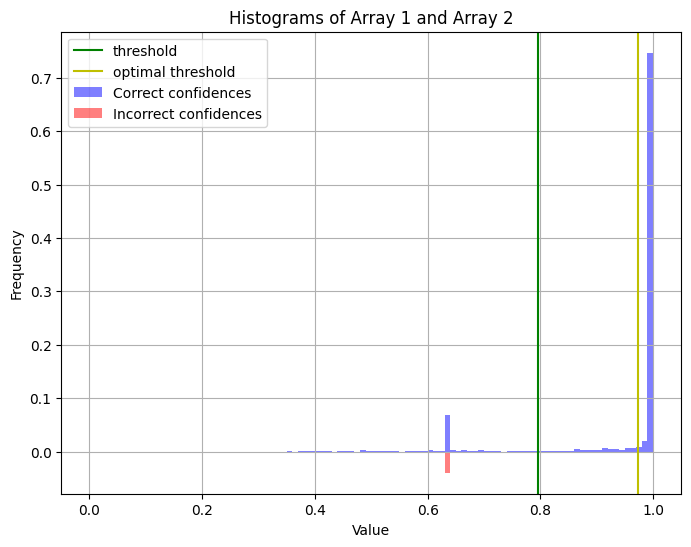

Average confidence for correct predictions: 0.9521
Average confidence for incorrect predictions: 0.6403
optimal_threshold :0.9723865985870361


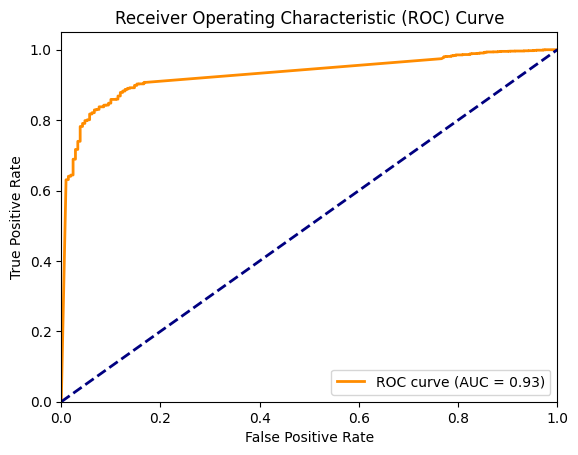

In [66]:
# analyze training data to find threshold

avg_correct, avg_incorrect,roc_threshold, roc_auc, fpr, tpr, thresholds = analyze_predictions(y_pred_train, Y_train)

print(f"Average confidence for correct predictions: {avg_correct:.4f}")
print(f"Average confidence for incorrect predictions: {avg_incorrect:.4f}")
 

# print(f'thresholds :{thresholds}')
print(f'optimal_threshold :{roc_threshold}')

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [60]:
# Make predictions
y_pred = model.predict(X_test)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


data size 784
number of "correct" predictions 686
number of "incorrect" predictions 98
Total accuracy on the given data : 0.875


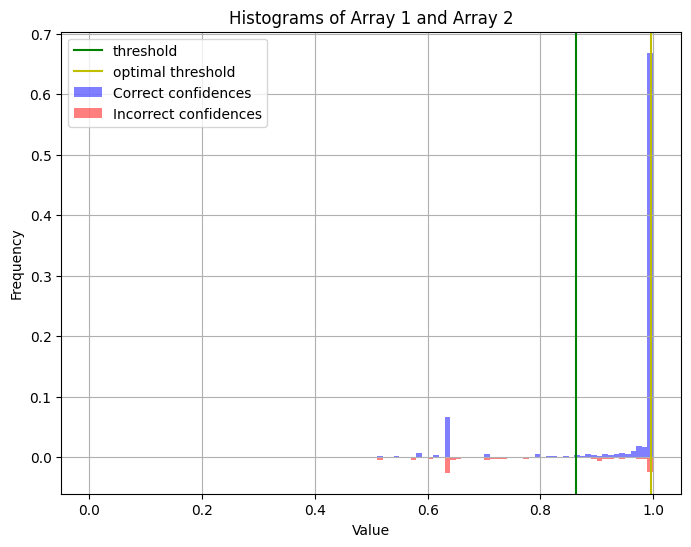

Average confidence for correct predictions: 0.9477
Average confidence for incorrect predictions: 0.7770
optimal_threshold :0.9961673617362976


In [61]:
# Analyse test data
avg_correct, avg_incorrect,roc_threshold_test, roc_auc, fpr, tpr, thresholds = analyze_predictions(y_pred, Y_test)

print(f"Average confidence for correct predictions: {avg_correct:.4f}")
print(f"Average confidence for incorrect predictions: {avg_incorrect:.4f}")
 

# print(f'thresholds :{thresholds}')
print(f'optimal_threshold :{roc_threshold_test}')


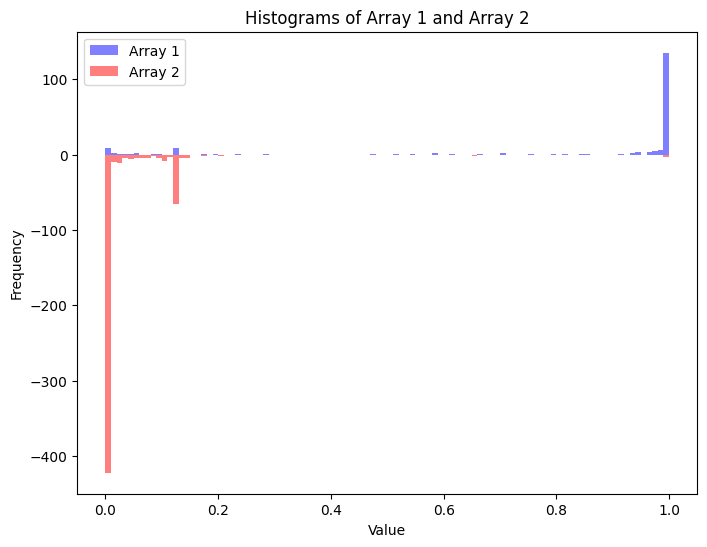

784, 200, 584
class 0 cor conf 0.8348683714866638
class 0 incor conf 0.04421595484018326


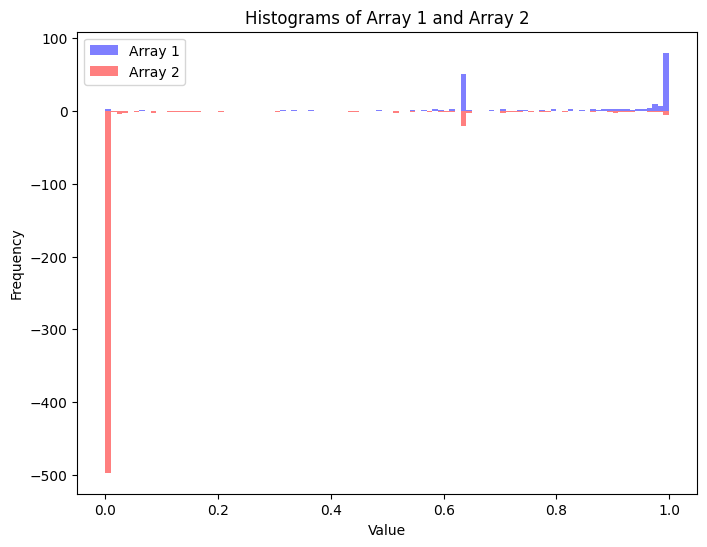

784, 200, 584
class 1 cor conf 0.8365775346755981
class 1 incor conf 0.08560895919799805


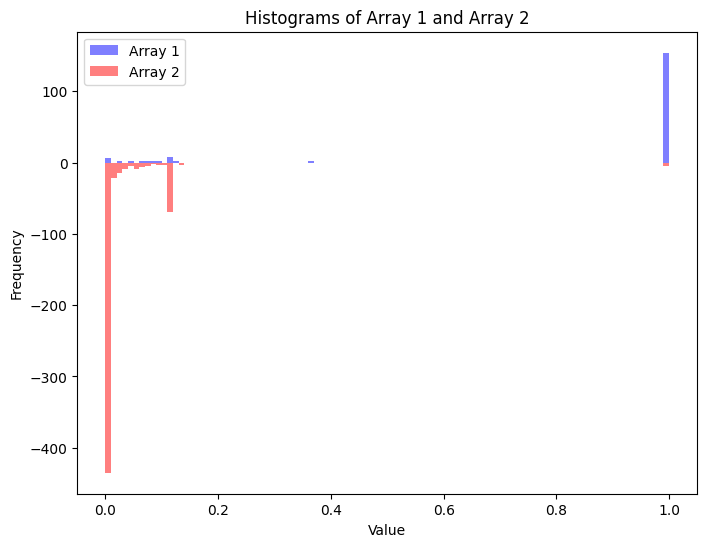

784, 184, 600
class 2 cor conf 0.8514726758003235
class 2 incor conf 0.0352177694439888


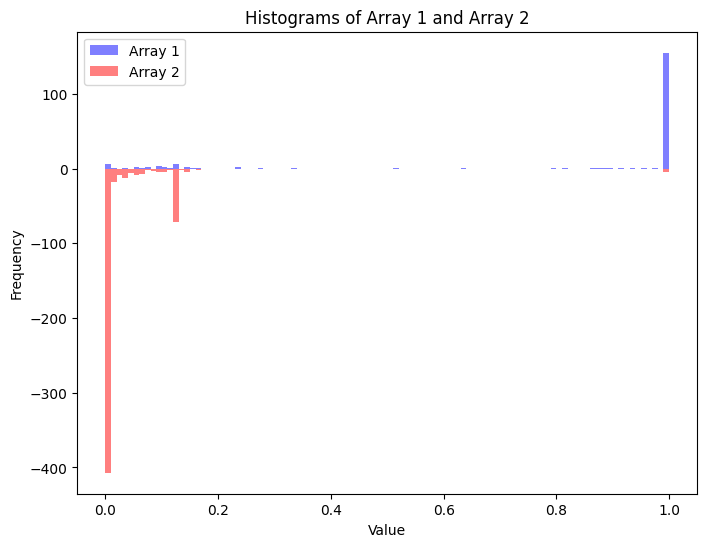

784, 200, 584
class 3 cor conf 0.8425851464271545
class 3 incor conf 0.04721643403172493


In [62]:
# prob dist classwise

for i in range(4):

    one_hot_coding_mask = Y_test[:,i].astype(bool)
    inv_one_hot_coding_mask = ~ one_hot_coding_mask

    class_i_correct_conf = y_pred[:,i][one_hot_coding_mask]
    class_i_incorrect_conf = y_pred[:,i][inv_one_hot_coding_mask]

    num_bins = 100
    bin_range = (0,1)
    # Compute histograms with the same range and bins
    hist1, bins = np.histogram(class_i_correct_conf, bins=num_bins, range=bin_range,density=False)
    hist2, _ = np.histogram(class_i_incorrect_conf, bins=num_bins, range=bin_range,density= False)

    hist1 = hist1  #/ (len(hist1) + len(hist2))
    hist2 = hist2  #/ (len(hist2) + len(hist1))

    # Set the bin centers for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Plot histograms
    plt.figure(figsize=(8, 6))

    # Plot the first histogram (going up)
    plt.bar(bin_centers, hist1, width=(bins[1] - bins[0]), color='blue', alpha=0.5, label='Array 1')

    # Plot the second histogram (going down)
    plt.bar(bin_centers, -hist2, width=(bins[1] - bins[0]), color='red', alpha=0.5, label='Array 2')

    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histograms of Array 1 and Array 2')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()


    print(f'{len(Y_test)}, {len(class_i_correct_conf)}, {len(class_i_incorrect_conf)}')

    print(f'class {i} cor conf {np.mean(class_i_correct_conf)}')
    print(f'class {i} incor conf {np.mean(class_i_incorrect_conf)}')


100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step

Accuracy on training data with unidentified class: 0.7746875


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Yes
Accuracy on test data with unidentified class: 0.7028061224489796
Number of unidentified instances in training data: 707 out of 3200 ( or ) 22.09375%
Number of unidentified instances in test data: 210 out of 784 ( or ) 26.785714285714285%
confusion matrix


<Figure size 1000x700 with 0 Axes>

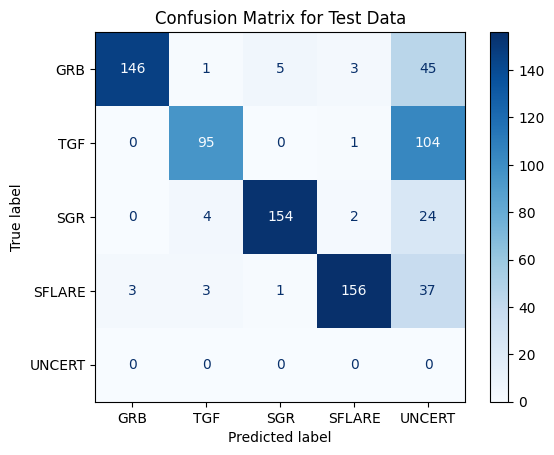

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# the threshold used in final analysis
threshold = roc_threshold

# Evaluate on training data
train_predictions, train_unidentified_count = predict_with_unidentified(model, X_train, threshold)
train_accuracy = np.mean(train_predictions == np.argmax(Y_train, axis=1))
print(f'\nAccuracy on training data with unidentified class: {train_accuracy}\n\n')

# Evaluate on validation data
test_predictions, test_unidentified_count = predict_with_unidentified(model, X_test, threshold)

# Check if Y_test is one-hot encoded or not
if Y_test.ndim > 1:
    print("Yes")
    test_true_labels = np.argmax(Y_test, axis=1)
else:
    test_true_labels = Y_test

test_accuracy = np.mean(test_predictions == test_true_labels)
print(f'Accuracy on test data with unidentified class: {test_accuracy}')

print(f'Number of unidentified instances in training data: {train_unidentified_count} out of {len(Y_train)} ( or ) {train_unidentified_count/len(Y_train) * 100}%')
print(f'Number of unidentified instances in test data: {test_unidentified_count} out of {len(Y_test)} ( or ) {test_unidentified_count/len(Y_test) * 100}%')

print("confusion matrix")
conf_matrix = confusion_matrix(test_true_labels, test_predictions, labels=[0, 1, 2, 3, 4])

plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['GRB', 'TGF', 'SGR', 'SFLARE', 'UNCERT'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Test Data')
plt.show()

In [64]:
# Percentages of test data with confidence

percent_right, percent_wrong, percent_uncertain = analyze_predictions_with_threshold(y_pred, Y_test, threshold)

print(f"Percentage of confidently right predictions: {percent_right:.2f}%")
print(f"Percentage of confidently wrong predictions: {percent_wrong:.2f}%")
print(f"Percentage of uncertain predictions: {percent_uncertain:.2f}%")
print(f"Accuracy of predictions given the model is confident :{percent_right/ (percent_right+percent_wrong)}")

Percentage of confidently right predictions: 70.28%
Percentage of confidently wrong predictions: 2.93%
Percentage of uncertain predictions: 26.79%
Accuracy of predictions given the model is confident :0.9599303135888502


In [65]:
gg

NameError: name 'gg' is not defined

*Krushna's Model*


In [4]:
import numpy as np
import os
import glob
import time

# importing data
event_types = {1:'GRB',2:'TGF',3:'SGR',4:'SFLARE'}

test_dir = os.path.join('/kaggle/input/dcl-00/DCL_ds0/test')  
train_dir = os.path.join('/kaggle/input/dcl-00/DCL_ds0/train')

# Replace 'your_search_string' with the string you are looking for in file names
search_string = 'bn'

search_pattern = os.path.join(test_dir, f'*{search_string}*')
test_files = glob.glob(search_pattern)

search_pattern = os.path.join(train_dir, f'*{search_string}*')
train_files = glob.glob(search_pattern)
import json

json_data_path = '/kaggle/input/dcl-00/DCL_ds0/params.json'
with open(json_data_path, 'r') as file:
    try:
        json_data = json.load(file)
        print(json_data)
    except json.JSONDecodeError:
        print(f"Error: JSON decode failed for file '{file_path}'")

dno = json_data['number of data points']

try:
    chrn = len(json_data['channel ranges'])
except:
    chrn = 1
    
try:
    t = json_data['time interval'][1]-json_data['time interval'][0]
except:
    t='n/a'
    
# Calculating the number of points in each binnning
bin_list = json_data['bin list']
dno_list = (chrn * len(bin_list)) * [dno]
data_total = sum(dno_list)
check_data = np.loadtxt(train_files[1], delimiter='\t').astype(np.int32)
len_data = len(check_data)
print(dno_list)

if data_total == len_data and len(dno_list) == len(bin_list) * chrn:
    print('\nbin edges calculated correctly')
else:
    print('inconsistency in bin edges calculated and data')
    print(data_total)
    print(len_data)
    
print('\nchannel range no',chrn)
print('number of data points',dno)
print('time interval',t)

import numpy as np

def process_file_krushna(file, X, Y, event_counter, dno_list):
    """
    Processes a single file and adds its data to the dataset.
    file: path to the file to be processed
    X: list of datasets to be appended to
    Y: list of labels of data
    event_counter: dictionary counting events
    dno_list: list of number of data points in each binning as calculated previously
    
    Returns updated X, Y, and event_counter
    """
    # Fetch data from file and check if label is considered
    event_type, event_name = file.split('/')[-1].split('_')
    loaded_data = np.loadtxt(file, delimiter='\t').astype(np.int32)
    
    if event_type not in event_counter:
        return X, Y, event_counter
    
    y = [0, 0, 0, 0]
    
    # Setting and updating Y
    for key, value in event_types.items():
        if value in file.split('\\')[-1]:
            y[key - 1] = 1
            Y.append(y)
            event_counter[value] += 1
    
    channel_1_data = []
    channel_2_data = []

    # Initialize lists to hold data slices
    for i in range(0,len(loaded_data),998):
        channel_1_data.extend(loaded_data[i:i+499])
        channel_2_data.extend(loaded_data[i+499:i+998])
    
    X.append([channel_1_data, channel_2_data])
    
    return X, Y, event_counter



# initializing train and test sets
X_train = []
Y_train = []
train_event_counter = {'GRB':0,'TGF':0,'SGR':0,'SFLARE':0}

X_test = []
Y_test = []
test_event_counter = {'GRB':0,'TGF':0,'SGR':0,'SFLARE':0}

# print(process_file(train_files[1],X_train,Y_train,train_event_counter))

# processing train and test data sets
for file in train_files:
    X_train,Y_train,train_event_counter = process_file_krushna(file,X_train,Y_train,train_event_counter,dno_list)
print('training events\n',train_event_counter)
print('total events : ', sum([i for i in train_event_counter.values()]))
Y_train = np.array(Y_train)
X_train = np.array(X_train)
print('shape of Y_train', Y_train.shape)
print('shape of X_train', X_train.shape)

for file in test_files:
    X_test,Y_test,test_event_counter = process_file_krushna(file,X_test,Y_test,test_event_counter,dno_list)
print('testing events\n',test_event_counter)
print('total events : ', sum([i for i in test_event_counter.values()]))
Y_test = np.array(Y_test)
X_test = np.array(X_test)
print('shape of Y_test', Y_test.shape)
print('shape of X_test', X_test.shape)
print(X_train[1:2])


{'bin list': [0.001, 0.005, 0.01, 0.1, 0.5, 1, 5], 'time interval': 'n/a', 'number of data points': 499, 'data set name': 'DCL_ds0', 'data set path': 'C:\\Users\\arpan\\OneDrive\\Documents\\GRB\\data\\DCL_ds0', 'channel ranges': [[3, 50], [51, 124]], 'ratio': 0.25}
[499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499]

bin edges calculated correctly

channel range no 2
number of data points 499
time interval n/a
training events
 {'GRB': 800, 'TGF': 800, 'SGR': 800, 'SFLARE': 800}
total events :  3200
shape of Y_train (3200, 4)
shape of X_train (3200, 2, 3493)
testing events
 {'GRB': 200, 'TGF': 200, 'SGR': 184, 'SFLARE': 200}
total events :  784
shape of Y_test (784, 4)
shape of X_test (784, 2, 3493)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


In [5]:
# Load the second model
from keras.models import load_model
model_path_2 = r"/kaggle/input/krushna_model_dcl/keras/default/1/model_dcl-00.h5" # second DCL model
model_2 = load_model(model_path_2)
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 2, 64)          │       223,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 2, 32)          │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 2, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,390 (939.03 KB)

 Trainable params: 240,388 (939.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
data size 3200
number of "correct" predictions 2872
number of "incorrect" predictions 328
Total accuracy on the given data : 0.8975


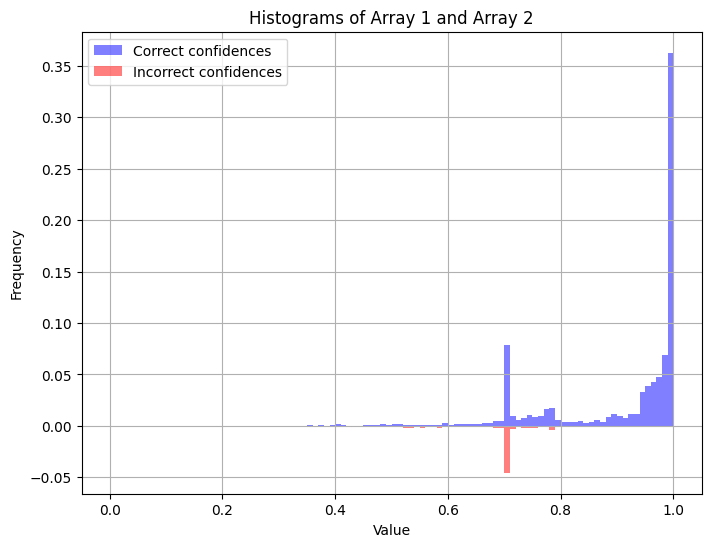

Average confidence for correct predictions: 0.9098
Average confidence for incorrect predictions: 0.6672
Threshold :  0.7884562015533447


In [6]:
avg_correct, avg_incorrect = analyze_predictions(model_2.predict(X_train), Y_train)

print(f"Average confidence for correct predictions: {avg_correct:.4f}")
print(f"Average confidence for incorrect predictions: {avg_incorrect:.4f}")

threshold = (avg_correct + avg_incorrect)/2

print("Threshold : ",threshold)

In [22]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def find_threshold(model, Y_train, threshold_range=np.arange(0.5, 1.0, 0.02)):

    Y_pred = model.predict(X_train)
    predicted_probs = np.max(Y_pred, axis=1)  

    if Y_train.ndim > 1:
        train_true_labels = np.argmax(Y_train, axis=1)
    else:
        train_true_labels = Y_train

    best_f1 = 0
    best_threshold = 0

    # Loop over the threshold range to find the best threshold
    for threshold in threshold_range:
        predicted_labels = np.where(predicted_probs < threshold, 0, 1)

        # Calculate precision, recall, F1-score for this threshold
        precision = precision_score(train_true_labels, predicted_labels, average='weighted', zero_division=0)
        recall = recall_score(train_true_labels, predicted_labels, average='weighted')
        f1 = f1_score(train_true_labels, predicted_labels, average='weighted')

        print(f'Threshold: {threshold}, Precision: {precision}, Recall: {recall}, F1: {f1}')

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print(f'Best Threshold: {best_threshold} with F1 Score: {best_f1}')
    
    return best_threshold, best_f1

In [26]:
threshold, F1 = find_threshold(model_2,Y_train,threshold_range=np.arange(0.5, 0.8, 0.05))

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold: 0.5, Precision: 0.12410318887664133, Recall: 0.25375, F1: 0.11040716862879543
Threshold: 0.55, Precision: 0.1280983152550196, Recall: 0.2553125, F1: 0.11632919382406964
Threshold: 0.6000000000000001, Precision: 0.13065979754582482, Recall: 0.256875, F1: 0.12135941209423637
Threshold: 0.6500000000000001, Precision: 0.13855137233322676, Recall: 0.25875, F1: 0.12848282304899306
Threshold: 0.7000000000000002, Precision: 0.13006559007008037, Recall: 0.25375, F1: 0.13156399083753853
Threshold: 0.7500000000000002, Precision: 0.08427037822730679, Recall: 0.1690625, F1: 0.10522920973302259
Threshold: 0.8000000000000003, Precision: 0.06997060130584896, Recall: 0.1328125, F1: 0.08843709880005007
Best Threshold: 0.7000000000000002 with F1 Score: 0.13156399083753853


In [28]:
# Make predictions
y_pred = model_2.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


data size 784
number of "correct" predictions 681
number of "incorrect" predictions 103
Total accuracy on the given data : 0.8686224489795918


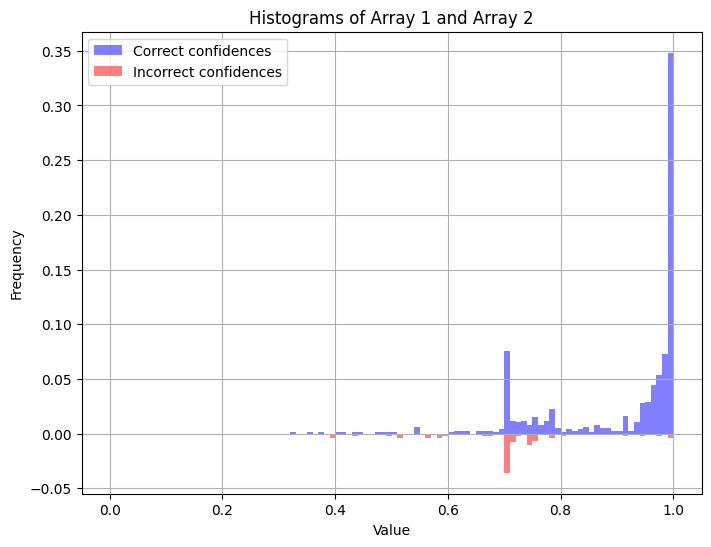

Average confidence for correct predictions: 0.9068
Average confidence for incorrect predictions: 0.6859
0.7963358759880066


In [29]:
# Analyse test data

avg_correct, avg_incorrect = analyze_predictions(y_pred, Y_test)

print(f"Average confidence for correct predictions: {avg_correct:.4f}")
print(f"Average confidence for incorrect predictions: {avg_incorrect:.4f}")

threshold = (avg_correct + avg_incorrect)/2
print(threshold)

In [30]:
threshold, F1 = find_threshold(model_2,Y_train,threshold_range=np.arange(0.5, 0.8, 0.05))

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold: 0.5, Precision: 0.12410318887664133, Recall: 0.25375, F1: 0.11040716862879543
Threshold: 0.55, Precision: 0.1280983152550196, Recall: 0.2553125, F1: 0.11632919382406964
Threshold: 0.6000000000000001, Precision: 0.13065979754582482, Recall: 0.256875, F1: 0.12135941209423637
Threshold: 0.6500000000000001, Precision: 0.13855137233322676, Recall: 0.25875, F1: 0.12848282304899306
Threshold: 0.7000000000000002, Precision: 0.13006559007008037, Recall: 0.25375, F1: 0.13156399083753853
Threshold: 0.7500000000000002, Precision: 0.08427037822730679, Recall: 0.1690625, F1: 0.10522920973302259
Threshold: 0.8000000000000003, Precision: 0.06997060130584896, Recall: 0.1328125, F1: 0.08843709880005007
Best Threshold: 0.7000000000000002 with F1 Score: 0.13156399083753853


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Accuracy on training data with unidentified class: 0.8528125


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Yes
Accuracy on test data with unidentified class: 0.826530612244898
Number of unidentified instances in training data: 254
Number of unidentified instances in test data: 69
confusion matrix


<Figure size 1000x700 with 0 Axes>

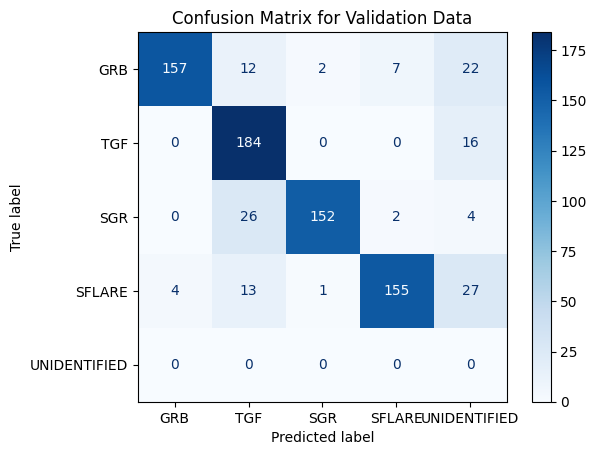

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


# Evaluate on training data
train_predictions, train_unidentified_count = predict_with_unidentified(model_2, X_train, threshold)
train_accuracy = np.mean(train_predictions == np.argmax(Y_train, axis=1))
print(f'\nAccuracy on training data with unidentified class: {train_accuracy}\n\n')

# Evaluate on validation data
test_predictions, test_unidentified_count = predict_with_unidentified(model_2, X_test, threshold)

# Check if Y_test is one-hot encoded or not
if Y_test.ndim > 1:
    print("Yes")
    test_true_labels = np.argmax(Y_test, axis=1)
else:
    test_true_labels = Y_test

test_accuracy = np.mean(test_predictions == test_true_labels)
print(f'Accuracy on test data with unidentified class: {test_accuracy}')

print(f'Number of unidentified instances in training data: {train_unidentified_count}')
print(f'Number of unidentified instances in test data: {test_unidentified_count}')

print("confusion matrix")
conf_matrix = confusion_matrix(test_true_labels, test_predictions, labels=[0, 1, 2, 3, 4])

plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['GRB', 'TGF', 'SGR', 'SFLARE', 'UNIDENTIFIED'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Validation Data')
plt.show()


In [32]:
confidence_threshold = 0.7

percent_right, percent_wrong, percent_uncertain = analyze_predictions_with_threshold(y_pred, Y_test, confidence_threshold)

print(f"Percentage of confidently right predictions: {percent_right:.2f}%")
print(f"Percentage of confidently wrong predictions: {percent_wrong:.2f}%")
print(f"Percentage of uncertain predictions: {percent_uncertain:.2f}%")

Percentage of confidently right predictions: 82.65%
Percentage of confidently wrong predictions: 8.55%
Percentage of uncertain predictions: 8.80%
